# Φάση 3: Υβριδικό σύστημα ανάκτησης

## Στόχος
Σε αυτή τη φάση συνδυάζουμε τα πλεονεκτήματα των δύο προηγούμενων μεθόδων:
*  **Lexical Search (Elasticsearch - BM25):** Εξαιρετικό στο να βρίσκει ακριβείς λέξεις-κλειδιά και σπάνιους όρους (High Recall).
*  **Semantic Search (Dense Retrieval - Embeddings):** Εξαιρετικό στο να κατανοεί το νόημα και το πλαίσιο (High Precision).

## Μεθοδολογία: Retrieve & Re-rank
Η διαδικασία ακολουθεί το μοντέλο **"Pipeline"**:
1.  **Stage 1 (Retrieval):** Το Elasticsearch ανακτά τα top-200 έγγραφα με βάση το BM25.
2.  **Stage 2 (Re-ranking):** Ένα μοντέλο BERT (`all-MiniLM-L6-v2`) υπολογίζει τη σημασιολογική ομοιότητα μόνο για αυτά τα 200 έγγραφα.
3.  **Stage 3 (Fusion):** Οι κατατάξεις συνδυάζονται με τον αλγόριθμο **Reciprocal Rank Fusion (RRF)**.

In [ ]:
import pandas as pd
import numpy as np
import faiss
import os
import subprocess
import re
import html
import unicodedata
import nltk
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('punkt_tab')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')

DOCS_PATH = "../data/documents.csv"
QUERIES_PATH = "../data/queries.csv"
QRELS_PATH = "../data/qrels.txt"
TREC_EVAL_PATH = "../../trec_eval/trec_eval.exe" 
RESULTS_DIR = "../results/results_phase3"

ES_INDEX = "ir_phase1_showcase"
MODEL_NAME = 'all-MiniLM-L6-v2' 


N_RETRIEVE = 200  
K_RERANK = 50     
RRF_K = 10        

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anthi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anthi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\anthi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Στρατηγική Διπλής Επεξεργασίας

Για να μεγιστοποιήσουμε την απόδοση, χρησιμοποιούμε διαφορετική στρατηγική καθαρισμού για κάθε στάδιο:
* **Για το Elasticsearch (Φάση 1):** Εφαρμόζουμε **Stemming** και αφαίρεση Stopwords.
* **Για το BERT Model (Φάση 2):** Κρατάμε τα σημεία στίξης και τα stopwords.

In [ ]:
boilerplate_phrases = [
    "the main objective of this project", "the aim of this project",
    "this project aims to", "this proposal aims to", "the goal of this proposal",
    "in this project", "in this proposal", "the proposed research",
    "to achieve this goal", "the overall objective",
    "aim of this project is to", "goal of this project is to",
    "objective of this project is to", "the aim of this project is",
    "objective of the project is to", "the goal of this project is",
    "goal of this proposal is to", "aim of the project is to",
    "aim of this proposal is to", "objective of this proposal is to",
    "the objective of this project is", "goal of the project is to",
    "the aim of this proposal is", "the aim of the project is",
    "the goal of this proposal is", "the objective of this proposal is",
    "main objective of this project is", "main objective of the project is",
    "the main objective of the project", "overall objective of the project is",
    "the overall objective of the project", "the main goal of this project",
    "state of the art", "the current state of the art", 
    "beyond the state of the art", "the state of the art in",
    "advance the state of the art", "of the state of the art",
    "beyond the current state of the", "will use state of the art",
    "will be carried out", "proof of concept", "feasibility study",
    "feasibility study of a", "understanding the role of", 
    "elucidating the role of", "at the end of the project",
    "will be carried out", "there is an urgent need to",
    "is one of the most important", "development of a new",
    "development of a novel", "development of an innovative",
    "research and innovation", "european union", "horizon 2020", "h2020", "fp7",
    "grant agreement", "the beneficiaries of the sme instrument",
    "establishing services enhancing the innovation management",
    "enhancing the innovation management capacity of",
    "the innovation management capacity of smes",
    "services enhancing the innovation management capacity",
    "innovation management capacity of smes in",
    "significant innovation activities and high potential",
    "smes with significant innovation activities and",
    "with significant innovation activities and high",
    "innovation activities and high potential for",
    "enhance the innovation management capacity of"
]
boilerplate_phrases.sort(key=len, reverse=True)

safe_noise = {
    "project", "aim", "proposal", "consortium", "summary", 
    "objective", "work", "package", "action", "activities",
    "main", "specific", "within", "during", "result", "presented",
    "paper", "study", "report", "deliverable", "task", "partners"
}

nltk_stops = set(stopwords.words('english'))
full_stopwords_list = nltk_stops.union(safe_noise)
stemmer = PorterStemmer()

def clean_for_phase1(text):
    if not isinstance(text, str): return ""
    
    text = re.sub(r'\\[nrtfv]', ' ', text)
    text = html.unescape(text)
    text = unicodedata.normalize('NFKC', text)
    
    for phrase in boilerplate_phrases:
        text = re.sub(re.escape(phrase), " ", text, flags=re.IGNORECASE)
            
    text = re.sub(r'[^a-zA-Z0-9\s:]', ' ', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    if not text: return
    text_no_punct = text.replace(':', ' ')
    tokens = word_tokenize(text_no_punct)
    filtered = [w for w in tokens if w not in full_stopwords_list and len(w) > 1]
    stems = [stemmer.stem(w) for w in filtered]
    
    return " ".join(stems)

def clean_for_phase2(text):
    
    if not isinstance(text, str): return ""
    text = html.unescape(text)
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'[^a-zA-Z0-9\s\.,\?!:;@%#\+\-&<>]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text.lower()

In [24]:
def load_raw_documents(path):
    try:
        df = pd.read_csv(path, header=None, dtype=str)
        doc_map = {}
        for _, row in df.iterrows():
            if pd.isna(row[0]) or str(row[0]).strip() == "": continue
            doc_id = str(row[0]).strip()
            if not doc_id[0].isdigit(): continue 
            raw_text = str(row[1])
            doc_map[doc_id] = raw_text 
            
        return doc_map
    except Exception as e:
        print(e)
        return {}

In [25]:
def save_and_eval(all_results):
    k_levels = [20, 30, 50]
    for k in k_levels:
        run_id = f"phase3_results_k{k}"
        filename = os.path.join(RESULTS_DIR, f"{run_id}.txt")
        
        with open(filename, 'w', encoding='utf-8') as f:
            for qid, docid, score, rank in all_results:
                if rank <= k:
                    f.write(f"{qid}\tQ0\t{docid}\t{rank}\t{score:.6f}\t{run_id}\n")
        
        if os.path.exists(TREC_EVAL_PATH):
            print(f"\n--- Αξιολόγηση για k={k} ---")
            cmd = [TREC_EVAL_PATH, "-m", "map", "-m", "P.5,10,15,20", "-m", "recall.5,10,15,20,50", QRELS_PATH, filename]
            try:
                res = subprocess.run(cmd, capture_output=True, text=True)
                print(res.stdout.strip())
            except: pass

## Εκτέλεση Pipeline

Η συνάρτηση `run_pipeline()` υλοποιεί μια υβριδική στρατηγική τριών σταδίων, συνδυάζοντας την ταχύτητα και την ανάκληση του Elasticsearch με την ακρίβεια και την κατανόηση πλαισίου των Neural Networks.

Η διαδικασία ακολουθεί τα εξής βήματα για κάθε ερώτηση:

### Initialization & Data Loading
* **Σύνδεση:** Αρχικοποιείται η σύνδεση με το Elasticsearch και φορτώνεται το μοντέλο Sentence Transformer (`MODEL_NAME`).
* **Raw Document Lookup:** Φορτώνουμε τα **πρωτότυπα (raw)** κείμενα στη μνήμη.
  
> Το Elasticsearch περιέχει stemmed κείμενα. Το BERT μοντέλο όμως χρειάζεται φυσική γλώσσα. Γι' αυτό ανακτούμε το αρχικό κείμενο πριν το vectorization.

### Elasticsearch
Στο πρώτο στάδιο, λειτουργούμε ως **"Filter"**:
* **Preprocessing:** Η ερώτηση καθαρίζεται με τη `clean_for_phase1` (Stemming, Boilerplate Removal) για να ταιριάζει με το Index.
* **Advanced Boolean Query:** Αντί για απλό match, χρησιμοποιούμε σύνθετο query για ισορροπία Recall/Precision:
    * **MUST (match):** Υποχρεωτική παρουσία λέξεων με `fuzziness="AUTO"` και `operator="or"`. Εξασφαλίζει υψηλό Recall.
    * **SHOULD (match_phrase):** Δίνει "Bonus" σκορ αν οι λέξεις βρεθούν ως φράση.
    * **Exact Phrase:** `slop=0`, `boost=10.0` (Τεράστια επιβράβευση για ακριβή φράση).
    * **Near Phrase:** `slop=2`, `boost=2.0` (Μικρή επιβράβευση αν οι λέξεις είναι κοντά).
* **Candidate Generation:** Ανακτούμε ένα σύνολο υποψηφίων εγγράφων (`N_RETRIEVE`), π.χ. τα 200 πιο σχετικά.

### Embeddings
Στο δεύτερο στάδιο, λειτουργούμε ως **"Ranker"** στα υποψήφια έγγραφα:
* **Dual Cleaning:**
    * Τα κείμενα των υποψηφίων καθαρίζονται με `clean_for_phase2` (Διατήρηση στίξης/context).
    * Η ερώτηση καθαρίζεται επίσης με `clean_for_phase2`.
* **Vectorization:** Παράγονται embeddings για την ερώτηση και τα κείμενα.
* **Similarity Search:** Χρησιμοποιούμε **FAISS** (`IndexFlatIP`) για να υπολογίσουμε την ομοιότητα συνημιτόνου μεταξύ της ερώτησης και των 200 υποψηφίων.

### Reciprocal Rank Fusion - RRF
Στο τελικό στάδιο, συνδυάζουμε τις δύο κατατάξεις για να εξαλείψουμε τις αδυναμίες κάθε μεθόδου. Χρησιμοποιούμε τον αλγόριθμο **RRF**:

$$Score(d) = \frac{1}{k + Rank_{BM25}(d)} + \frac{1}{k + Rank_{Vector}(d)}$$

* **Rank_BM25:** Η σειρά κατάταξης από το Elasticsearch.
* **Rank_Vector:** Η σειρά κατάταξης από το FAISS.
* **k:** Σταθερά εξομάλυνσης (`RRF_K`).

Τα αποτελέσματα ταξινομούνται με βάση το RRF Score και κρατάμε τα κορυφαία `K_RERANK` για την τελική αξιολόγηση.

In [ ]:
def run_pipeline():
    if not os.path.exists(RESULTS_DIR): os.makedirs(RESULTS_DIR)

    try:
        es = Elasticsearch("http://localhost:9200")
        model = SentenceTransformer(MODEL_NAME)
    except Exception as e:
        print(e)
        return
    
    doc_lookup = load_raw_documents(DOCS_PATH)
    
    df_q = pd.read_csv(QUERIES_PATH, header=0, dtype=str)
    if df_q.empty: df_q = pd.read_csv(QUERIES_PATH, header=None, dtype=str)
    queries = list(zip(df_q.iloc[:,0], df_q.iloc[:,1]))
    
    all_final_results = []
    
    for i, (q_id, q_text) in enumerate(queries):

        # Elasticsearch
        q_elastic = clean_for_phase1(q_text)
        
        try:
            res = es.search(
                index=ES_INDEX,
                body={
                    "query": {
                        "bool": {
                            "must": [
                                {"match": {"text": {"query": q_elastic,"fuzziness": "AUTO","operator": "or"}}}
                            ],
                            "should": [
                                {"match_phrase": {"text": {"query": q_elastic, "slop": 0, "boost": 10.0}}},
                                {"match_phrase": {"text": {"query": q_elastic, "slop": 2, "boost": 2.0}}}
                            ]
                        }
                    },
                    "size": N_RETRIEVE, 
                    "_source": ["ID", "doc_id"] 
                }
            )
        except Exception as e:
            print(e)
            continue
        
        hits = res['hits']['hits']
        if not hits: continue
        
        candidates = []
        bm25_scores = []
        
        for h in hits:
            real_id = str(h['_source'].get('ID') or h['_id'])
            bm25_scores.append(h['_score'])
            
            raw_text = doc_lookup.get(real_id, "")
            clean_text_p2 = clean_for_phase2(raw_text)
            
            candidates.append({
                'id': real_id,
                'clean_text': clean_text_p2
            })

        # Embeddings
        q_bert = clean_for_phase2(q_text)
        cand_texts = [c['clean_text'] for c in candidates]
        doc_emb = model.encode(cand_texts, convert_to_numpy=True)
        qry_emb = model.encode([q_bert], convert_to_numpy=True)
        
        faiss.normalize_L2(doc_emb)
        faiss.normalize_L2(qry_emb)
        
        index = faiss.IndexFlatIP(doc_emb.shape[1])
        index.add(doc_emb)
        _, vec_indices = index.search(qry_emb, len(cand_texts))
        
        # Vector Ranks
        vector_ranks = {}
        for rank, idx in enumerate(vec_indices[0]):
            doc_id = candidates[idx]['id']
            vector_ranks[doc_id] = rank + 1

        # BM25 Ranks
        bm25_sorted_idx = np.argsort(bm25_scores)[::-1]
        bm25_ranks = {}
        for rank, idx in enumerate(bm25_sorted_idx):
            doc_id = candidates[idx]['id']
            bm25_ranks[doc_id] = rank + 1
            
        # Compute RRF
        rrf_results = []
        for c in candidates:
            doc_id = c['id']
            r_bm25 = bm25_ranks.get(doc_id, 1000)
            r_vec = vector_ranks.get(doc_id, 1000)
            
            score = (1 / (RRF_K + r_bm25)) + (1 / (RRF_K + r_vec))
            rrf_results.append({'id': doc_id, 'score': score})
            
        rrf_results.sort(key=lambda x: x['score'], reverse=True)
        
        for rank, res in enumerate(rrf_results[:K_RERANK]):
            all_final_results.append((
                q_id, res['id'], res['score'], rank + 1
            ))

    save_and_eval(all_final_results)

In [27]:
if __name__ == "__main__":
    run_pipeline()


--- Αξιολόγηση για k=20 ---
map                   	all	0.6485
P_5                   	all	0.9000
P_10                  	all	0.7600
P_15                  	all	0.6800
P_20                  	all	0.5700
recall_5              	all	0.3068
recall_10             	all	0.5051
recall_15             	all	0.6803
recall_20             	all	0.7513
recall_50             	all	0.7513

--- Αξιολόγηση για k=30 ---
map                   	all	0.7138
P_5                   	all	0.9000
P_10                  	all	0.7600
P_15                  	all	0.6800
P_20                  	all	0.5700
recall_5              	all	0.3068
recall_10             	all	0.5051
recall_15             	all	0.6803
recall_20             	all	0.7513
recall_50             	all	0.8678

--- Αξιολόγηση για k=50 ---
map                   	all	0.7447
P_5                   	all	0.9000
P_10                  	all	0.7600
P_15                  	all	0.6800
P_20                  	all	0.5700
recall_5              	all	0.3068
recall_10             	all	0.

## Σύγκριση Επιδόσεων (Phase 1 vs Phase 2 vs Phase 3)

Παρακάτω συγκρίνουμε τις καμπύλες **Precision-Recall** για τις τρεις φάσεις. Η **Φάση 3** αναμένεται να είναι πιο ψηλά και δεξιά, δείχνοντας καλύτερη ακρίβεια και ανάκληση.

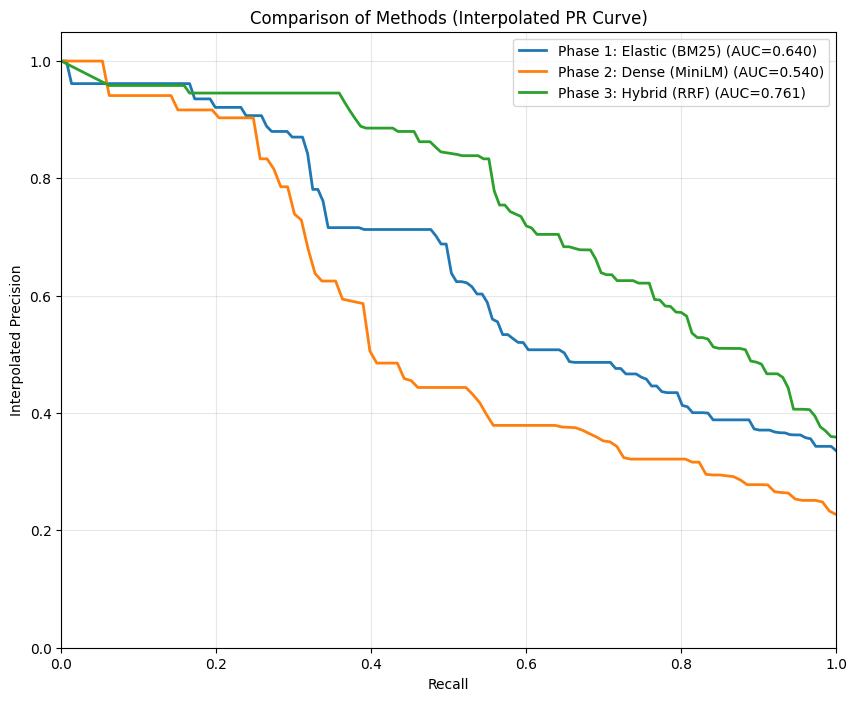

In [ ]:
def plot_smooth_pr_curves_fixed(qrels_file, results_config):

    qrels = {}
    with open(qrels_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 3: continue
            qid, docid = parts[0], parts[2]
            if qid not in qrels: qrels[qid] = set()
            qrels[qid].add(docid)

    plt.figure(figsize=(10, 8))
    
    for filepath, name in results_config:
        y_true = []
        y_scores = []
        
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5: continue
                qid, docid, score = parts[0], parts[2], float(parts[4])
                
                is_rel = 1 if (qid in qrels and docid in qrels[qid]) else 0
                y_true.append(is_rel)
                y_scores.append(score)
        
        if not y_true: continue
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        
        pr_auc = auc(recall, precision)
        pr_data = sorted(zip(recall, precision), key=lambda x: x[0])
        
        recall_sorted, precision_sorted = zip(*pr_data)
        recall_sorted = np.array(recall_sorted)
        
        precision_sorted = np.array(precision_sorted)
        precision_interp = np.maximum.accumulate(precision_sorted[::-1])[::-1]
        
        plt.plot(recall_sorted, precision_interp, lw=2, label=f'{name} (AUC={pr_auc:.3f})')

    plt.xlabel('Recall')
    plt.ylabel('Interpolated Precision')
    plt.title('Comparison of Methods (Interpolated PR Curve)')
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

my_results = [
    ("../results/results_phase1/phase1_results_k50.txt", "Phase 1: Elastic (BM25)"),
    ("../results/results_phase2/phase2_results_k50.txt", "Phase 2: Dense (MiniLM)"),
    ("../results/results_phase3/phase3_results_k50.txt", "Phase 3: Hybrid (RRF)")
]

plot_smooth_pr_curves_fixed(QRELS_PATH, my_results)